In [1]:
from Functions import *

In [2]:
Data = './DATA/Data_Customers_Clustered.csv'

DataClustered = pd.read_csv(Data)

In [3]:
DataClustered.head(2)

,Education,Marital_Status,Income,Kidhome,Teenhome,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,...,YearsSinceEnrolled,Age,Age_Group,MntTotal,MNTRegularProducts,HasChildren,AcceptedCmpTotal,HasAcceptedCmp,NumTotalPurchases,Cluster
0,Graduation,Single,58138.0,0,0,58,635,88,546,172,...,1,57,46-60,1617,1529,0,0,0,22,0
1,Graduation,Single,46344.0,1,1,38,11,1,6,2,...,0,60,46-60,27,21,1,0,0,4,1


In [4]:
DataClustered.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2205 entries, 0 to 2204
Data columns (total 35 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Education            2205 non-null   object 
 1   Marital_Status       2205 non-null   object 
 2   Income               2205 non-null   float64
 3   Kidhome              2205 non-null   int64  
 4   Teenhome             2205 non-null   int64  
 5   Recency              2205 non-null   int64  
 6   MntWines             2205 non-null   int64  
 7   MntFruits            2205 non-null   int64  
 8   MntMeatProducts      2205 non-null   int64  
 9   MntFishProducts      2205 non-null   int64  
 10  MntSweetProducts     2205 non-null   int64  
 11  MntGoldProds         2205 non-null   int64  
 12  NumDealsPurchases    2205 non-null   int64  
 13  NumWebPurchases      2205 non-null   int64  
 14  NumCatalogPurchases  2205 non-null   int64  
 15  NumStorePurchases    2205 non-null   i

In [5]:
X = DataClustered.drop('Response',axis=1)
y = DataClustered.Response

In [6]:
X.head(3)

,Education,Marital_Status,Income,Kidhome,Teenhome,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,...,YearsSinceEnrolled,Age,Age_Group,MntTotal,MNTRegularProducts,HasChildren,AcceptedCmpTotal,HasAcceptedCmp,NumTotalPurchases,Cluster
0,Graduation,Single,58138.0,0,0,58,635,88,546,172,...,1,57,46-60,1617,1529,0,0,0,22,0
1,Graduation,Single,46344.0,1,1,38,11,1,6,2,...,0,60,46-60,27,21,1,0,0,4,1
2,Graduation,Has_Partner,71613.0,0,0,26,426,49,127,111,...,0,49,46-60,776,734,0,0,0,20,0


In [7]:
# Columns For OneHotEncoding. No Response. And column Cluster
one_hot_cols = [
    "HasChildren",
    "HasAcceptedCmp",
    "AcceptedCmp1",
    "AcceptedCmp2",
    "AcceptedCmp3",
    "AcceptedCmp4",
    "AcceptedCmp5",
    "Complain",
    "Kidhome",
    "Teenhome",
    "YearsSinceEnrolled",
    "AcceptedCmpTotal",
    'Cluster',
    'Education',
    'Marital_Status',
    'Age_Group'
]

standard_cols = [
    "Income",
    "Age"
]

power_cols = X.columns[
    X.columns.str.startswith('Mnt') | X.columns.str.startswith('Num')
].tolist()

minmax_cols = [col for col in X.columns if col not in one_hot_cols + standard_cols + power_cols]

In [8]:
# for col in ['Education', 'Marital_Status']:
#     minmax_cols.remove(col)

In [9]:
minmax_cols

['Recency', 'DaysSinceEnrolled', 'MNTRegularProducts']

In [10]:
standard_cols

['Income', 'Age']

In [11]:
power_cols

['MntWines',
 'MntFruits',
 'MntMeatProducts',
 'MntFishProducts',
 'MntSweetProducts',
 'MntGoldProds',
 'NumDealsPurchases',
 'NumWebPurchases',
 'NumCatalogPurchases',
 'NumStorePurchases',
 'NumWebVisitsMonth',
 'MntTotal',
 'NumTotalPurchases']

# Using the DummyClassifier is important for comparing machine learning models because it establishes a basic benchmark. The DummyClassifier is a simple model that makes trivial predictions, such as always predicting the most frequent class or making random predictions. Comparing the performance of more complex models with this baseline helps to understand whether the models are truly capturing patterns in the data or merely outperforming a model that makes naive predictions. This ensures that improvements in performance are due to the model's ability to learn from the data and not due to luck or unnecessary complexity. In summary, the DummyClassifier provides a fundamental reference point for evaluating the real effectiveness of other machine learning models.

In [12]:
RANDOM_STATE = 42
from sklearn.dummy import DummyClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import StratifiedKFold,cross_validate
from imblearn.pipeline import Pipeline #PipeLine do Imlearn for Imbalanced Datasets!
from sklearn.feature_selection import SelectKBest, f_classif
from imblearn.under_sampling import RandomUnderSampler

models = {
    "DummyClassifier": DummyClassifier(
        strategy="stratified", random_state=RANDOM_STATE     #baseLine
    ),
    "DecisionTreeClassifier": DecisionTreeClassifier(random_state=RANDOM_STATE),
    "LogisticRegression": LogisticRegression(random_state=RANDOM_STATE),
    "KNNClassifier": KNeighborsClassifier(n_neighbors=5),
}

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

In [13]:
def pipeline_model(X, y, model, kf):
    
    preprocessing = ColumnTransformer(
        transformers=[
            ('OneHot', OneHotEncoder(drop='first'), one_hot_cols),
            ('Standard_process', StandardScaler(), standard_cols),
            ('min_max', MinMaxScaler(), minmax_cols),
            ('power_process', PowerTransformer(), power_cols),
            #remainder="passthrough"
        ]
    )
    
    pipeline = Pipeline(
        [
            ('preprossesing',preprocessing),
            ('feature_selection',SelectKBest(score_func=f_classif,k=10)),  #pegar as melhores features em modelo de classificacao
            ('RUS',RandomUnderSampler(random_state=42)),
            ('Model',model),
        ]
    
    )
    
    scores = cross_validate(
        pipeline,
        X,
        y,
        cv=kf,
        scoring=["accuracy", "precision", "recall", "roc_auc", "average_precision"],  #average_precision boa para datasets desbalanceados
        n_jobs=-1,
    )
 
    return scores

    

In [14]:
results = {
    "DummyClassifier": pipeline_model(X, y, models["DummyClassifier"], skf),
    "DecisionTreeClassifier": pipeline_model(X, y, models["DecisionTreeClassifier"], skf),
    "LogisticRegression": pipeline_model(X, y, models["LogisticRegression"], skf),
    "KNNClassifier": pipeline_model(X, y, models["KNNClassifier"], skf),
}


In [15]:
results = pd.DataFrame(results).T.reset_index().rename(columns={'index':'Models'})

In [16]:
results

,Models,fit_time,score_time,test_accuracy,test_precision,test_recall,test_roc_auc,test_average_precision
0,DummyClassifier,"[0.09146809577941895, 0.09294986724853516, 0.0...","[0.038468122482299805, 0.035042762756347656, 0...","[0.5124716553287982, 0.5034013605442177, 0.503...","[0.1542056074766355, 0.14485981308411214, 0.14...","[0.4925373134328358, 0.4626865671641791, 0.462...","[0.5042900470907494, 0.4866908771649773, 0.486...","[0.15304952129175473, 0.14865734269715697, 0.1..."
1,DecisionTreeClassifier,"[0.06679010391235352, 0.07778787612915039, 0.0...","[0.027011632919311523, 0.03418850898742676, 0....","[0.6621315192743764, 0.6326530612244898, 0.646...","[0.25301204819277107, 0.2254335260115607, 0.24...","[0.6268656716417911, 0.582089552238806, 0.6567...","[0.6488347034879081, 0.6209194668369383, 0.650...","[0.21722811197042827, 0.1971332833439517, 0.21..."
2,LogisticRegression,"[0.0807807445526123, 0.08177828788757324, 0.08...","[0.03390812873840332, 0.035901546478271484, 0....","[0.7732426303854876, 0.7573696145124716, 0.750...","[0.3486238532110092, 0.3387096774193548, 0.316...","[0.5671641791044776, 0.6268656716417911, 0.552...","[0.7512371298587278, 0.7405618964003512, 0.763...","[0.4396764207670612, 0.45989081519579855, 0.38..."
3,KNNClassifier,"[0.06681704521179199, 0.07180476188659668, 0.0...","[0.04288434982299805, 0.0418851375579834, 0.04...","[0.7346938775510204, 0.7052154195011338, 0.725...","[0.3188405797101449, 0.27972027972027974, 0.32...","[0.6567164179104478, 0.5970149253731343, 0.731...","[0.7590390294516721, 0.717874531087876, 0.7845...","[0.3490721395661345, 0.29679239729185697, 0.36..."


In [17]:
df_explode = results.columns[1:].tolist()

In [18]:
df_results_explode = results.explode(df_explode).reset_index(drop=True)

In [19]:
df_results_explode

,Models,fit_time,score_time,test_accuracy,test_precision,test_recall,test_roc_auc,test_average_precision
0,DummyClassifier,0.091468,0.038468,0.512472,0.154206,0.492537,0.50429,0.15305
1,DummyClassifier,0.09295,0.035043,0.503401,0.14486,0.462687,0.486691,0.148657
2,DummyClassifier,0.085489,0.038486,0.503401,0.14486,0.462687,0.486691,0.148657
3,DummyClassifier,0.079989,0.037501,0.487528,0.126168,0.409091,0.455212,0.14005
4,DummyClassifier,0.082982,0.040003,0.510204,0.149533,0.484848,0.499758,0.149598
5,DecisionTreeClassifier,0.06679,0.027012,0.662132,0.253012,0.626866,0.648835,0.217228
6,DecisionTreeClassifier,0.077788,0.034189,0.632653,0.225434,0.58209,0.620919,0.197133
7,DecisionTreeClassifier,0.079941,0.033032,0.646259,0.248588,0.656716,0.650551,0.215406
8,DecisionTreeClassifier,0.087044,0.035903,0.680272,0.275449,0.69697,0.686343,0.237331
9,DecisionTreeClassifier,0.090034,0.029919,0.69161,0.291667,0.742424,0.712545,0.255089


C:\Users\vinic\AppData\Local\Temp\ipykernel_1152\884056953.py:6: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  b.set_xticklabels(b.get_xticklabels(),fontsize=7)
C:\Users\vinic\AppData\Local\Temp\ipykernel_1152\884056953.py:6: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  b.set_xticklabels(b.get_xticklabels(),fontsize=7)
C:\Users\vinic\AppData\Local\Temp\ipykernel_1152\884056953.py:6: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  b.set_xticklabels(b.get_xticklabels(),fontsize=7)


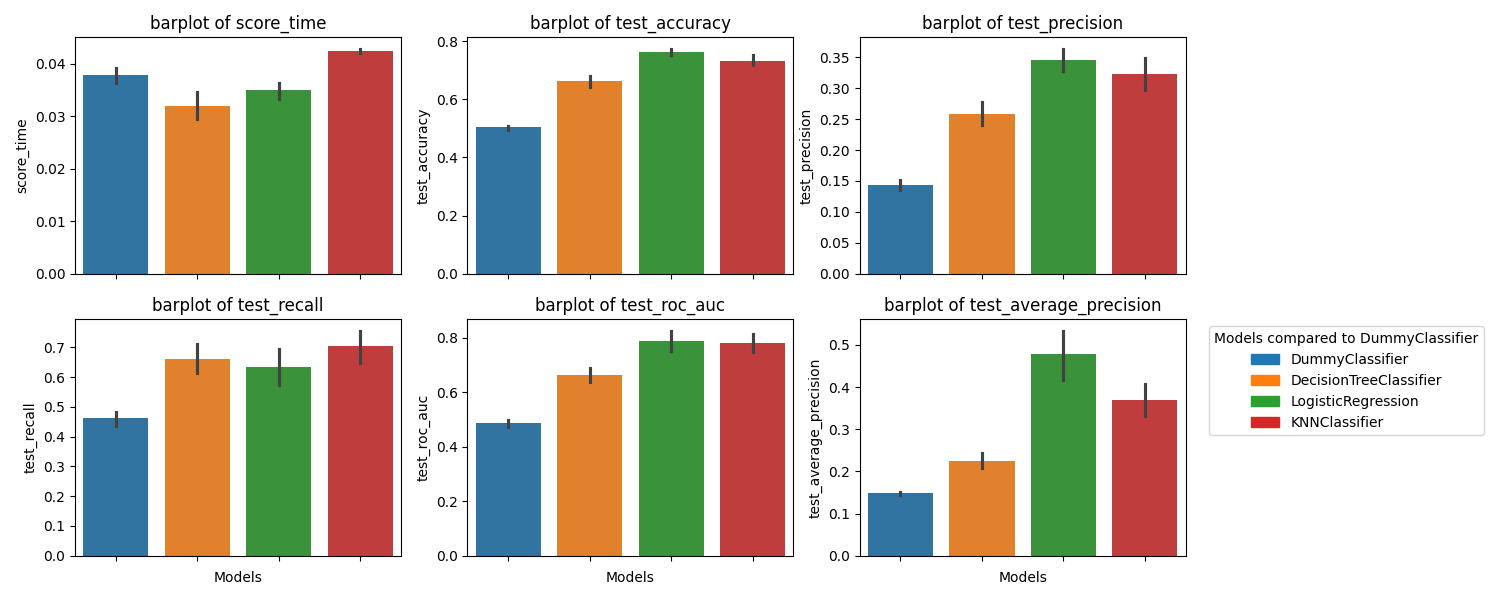

In [75]:
import matplotlib.patches as mpatches
fig ,axs = plt.subplots(ncols=3,nrows=2,figsize=(15,6),tight_layout=True,sharex=True)
cols = results.columns[2:].tolist()
for ax ,col in zip(axs.flatten(),cols):
    b = sns.barplot(x='Models',y=col,data=df_results_explode, ax=ax,hue='Models')
    b.set_xticklabels(b.get_xticklabels(),fontsize=7)
    b.set_title(f'barplot of {col}')
    models = df_results_explode['Models'].unique()
    palette = sns.color_palette(n_colors=len(models))
    handles = [mpatches.Patch(color=palette[i], label=model) for i, model in enumerate(models)]



plt.legend(handles=handles, bbox_to_anchor=(1.05, 1), loc='upper left',title='Models compared to DummyClassifier')

plt.show()

# This graph shows that the Logistic Regression model would be the best for the project